In [147]:
import os
import re
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# MAPPING DATASETS

In [2]:
# Map Kaggle and Mendeley labels to unified set
label_map = {
    "URTI": "URTI",
    "Healthy": "Healthy",
    "Asthma": "Asthma",
    "COPD": "COPD",
    "LRTI": "LRTI",
    "Pneumonia": "Pneumonia",
    "Bronchiectasis": "BRON",
    "Bronchiolitis": "BRON",
    "BRON": "BRON",
    "Lung Fibrosis":"Lung Fibrosis",
    "Plueral Effusion":"Plueral Effusion"
}

In [3]:
class Diagnosis():
  def __init__ (self, id, diagnosis, audio_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.audio_path = audio_path   

# CLEANING & PARSING: Mendeley Dataset

In [4]:
# extract labels for Mendeley dataset
path_mendeley = "audioDataMendeley/Audio files"

keep_upper = {"COPD", "BRON"}
diagnosis_list =[]

# Detect diagnosis text in the filename and format it properly.
def format_diagnosis_from_filename(filename):
    name, ext = os.path.splitext(filename)
    
    # Split on first underscore
    parts = name.split("_", 1)
    if len(parts) > 1:
        prefix, diag_segment = parts[0], parts[1]
        
        # Split the diagnosis segment by commas
        diag_parts = diag_segment.split(",")
        formatted_diag_parts = []
        for part in diag_parts:
            part_clean = part.strip()
            if part_clean.upper() in keep_upper:
                formatted_diag_parts.append(part_clean.upper())
            elif part_clean == "N":
                formatted_diag_parts.append("Healthy")
            else:
                formatted_diag_parts.append(part_clean.title())
        
        # Rejoin with commas
        new_diag_segment = ",".join(formatted_diag_parts)
        new_name = f"{prefix}_{new_diag_segment}"
    else:
        new_name = name
    
    return new_name + ext

# go through directory and only keep necessary files
mendeley_labels = []
data_mendeley = []
for c, file in enumerate(os.listdir(path_mendeley)):
    if file.endswith(".wav"):
        old_path = os.path.join(path_mendeley, file)

        if "heart failure" in file.lower() or "and" in file.lower():
            os.remove(old_path)
            continue

        new_filename = format_diagnosis_from_filename(file)
        new_path = os.path.join(path_mendeley, new_filename)
        
        # Rename the file
        os.rename(old_path, new_path)

        # make patient diagnosis csv
        filename_parts = new_filename.split("_")
        patient_id_pattern = r"\d+"

        # extract patient id and diagnosis from filename 
        match_id = re.search(patient_id_pattern,filename_parts[0])
        if match_id:
            patient_id_mendeley = int(match_id.group())

        diag_segment = filename_parts[1]
        patient_diagnosis_mendeley = diag_segment.split(",")[0].strip()
        
        data_mendeley.append([patient_id_mendeley,patient_diagnosis_mendeley])

        diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=patient_diagnosis_mendeley,
        audio_path=new_path
    ))
        
# export csv
patient_diagnosis_df_mendeley = pd.DataFrame(data_mendeley)
patient_diagnosis_df_mendeley.to_csv('audioDataMendeley/patient_diagnosis.csv', index=False)

In [94]:
#patient_diagnosis_df_mendeley[patient_diagnosis_df_mendeley[1] == 'URTI']
patient_diagnosis_df_mendeley[1].value_counts()


1
Healthy             105
Asthma               96
COPD                 27
Pneumonia            15
Lung Fibrosis        12
BRON                  9
Plueral Effusion      6
Name: count, dtype: int64

# PARSING DATASET: Kaggle

In [5]:
# Download latest version of the database 
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /Users/nikisingh/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [6]:
# extract lables for kaggle dataset
# Path to patient diagnosis CSV
diagnosis_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")

audio_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/")
files_kaggle = []
for file in os.listdir(audio_path_kaggle):
    if file.endswith(".wav"):
        files_kaggle.append(file)

files_kaggle = sorted(files_kaggle)

In [7]:
diag_dict_kaggle = { 101 : "URTI"}  
diagnosis_kaggle = pd.read_csv(diagnosis_path_kaggle)
  
for index , row in diagnosis_kaggle.iterrows():
    diag_dict_kaggle[row.iloc[0]] = row.iloc[1]

# Add kaggle files to diagnosis list
for c, f in enumerate(files_kaggle):
    patient_id = int(f.split('_')[0])
    raw_label = diag_dict_kaggle.get(patient_id, "Unknown")
    diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=label_map.get(raw_label, "Unknown"),
        audio_path=os.path.join(audio_path_kaggle, f)
    ))

In [95]:
#diagnosis_kaggle[diagnosis_kaggle['URTI'] == 'URTI']
diagnosis_kaggle['URTI'].value_counts()

URTI
COPD              64
Healthy           26
URTI              13
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

# FEATURE EXTRACTION

In [8]:
unique_labels = sorted(set(d.diagnosis for d in diagnosis_list))

# Create a mapping from label
to_index = {label: idx for idx, label in enumerate(unique_labels)}
to_index

{'Asthma': 0,
 'BRON': 1,
 'COPD': 2,
 'Healthy': 3,
 'LRTI': 4,
 'Lung Fibrosis': 5,
 'Plueral Effusion': 6,
 'Pneumonia': 7,
 'URTI': 8}

In [9]:
# Collect all audio files and diagnosises in sets
audio_paths = [s.audio_path for s in diagnosis_list]
labels = [to_index[s.diagnosis] for s in diagnosis_list]

### Base Model

In [10]:
def extract_basic_model_features(audio_paths, target_sr=22050):
    # Load all audio files and return the audio file path, data, sample rate, and duration
    # Data is audio time series
    features = []

    for audio_file in audio_paths:
        y, sr = librosa.load(audio_file, sr=target_sr)  # sample rate is none bc of frequent low-frequency

        # compute STFT for chroma + contrast
        stft = np.abs(librosa.stft(y))

        # compute 1D audio features
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)

        # concatenate all features into one 1D vector
        combined = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

        features.append(combined)

    # convert feature list to array (samples, feature_length)
    features = np.array(features)

    # pad along feature axis to ensure equal length
    max_len = max(f.shape[0] for f in features)
    padded = np.zeros((len(features), max_len))

    for i, f in enumerate(features):
        padded[i, :len(f)] = f

    # add channel dimension
    # Source: Appendix 2
    padded = padded[..., np.newaxis]  # shape: (samples, feature_length, 1) 

    return padded


### Data Augmented Model

In [11]:
def augment_audio(audio, sr, augmentation_type):
    if augmentation_type == 'noise':
        # generate an array of random numbers
        noise = np.random.randn(len(audio))
        # add noise to original audio
        audio = audio + 0.005 * noise
        # clip audio so values are within valid range (-1 to 1)
        audio = np.clip(audio, -1.0, 1.0)
    elif augmentation_type == 'pitch_shift':
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    elif augmentation_type == 'remix':
        # detect non-silent intervals
        intervals = librosa.effects.split(audio, top_db=20)
        # only remix if there are multiple intervals
        if len(intervals) > 1:  
            np.random.shuffle(intervals)
            audio = librosa.effects.remix(audio, intervals)
        audio = np.clip(audio, -1.0, 1.0)
    return audio

In [12]:
def extract_augmented_model_features(audio_paths,labels,target_sr=22050,augmentation_types=['noise', 'pitch_shift', 'time_stretch']):
    features = []
    new_labels = []

    # add original features to list + augmented features
    for i, audio_file in enumerate(audio_paths):

        y, sr = librosa.load(audio_file, sr=target_sr)  # sample rate is none bc of frequent low-frequency

        # data augmentation loop
        for aug in augmentation_types:
            y_aug = augment_audio(y.copy(), sr, aug)

            stft_aug = np.abs(librosa.stft(y_aug))
            mfccs = np.mean(librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=40), axis=1)
            chroma = np.mean(librosa.feature.chroma_stft(S=stft_aug, sr=sr), axis=1)
            mel = np.mean(librosa.feature.melspectrogram(y=y_aug, sr=sr), axis=1)
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft_aug, sr=sr), axis=1)
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y_aug), sr=sr), axis=1)

            combined_aug = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

            features.append(combined_aug)
            new_labels.append(labels[i])

    # convert feature list to array (samples, feature_length)
    features = np.array(features)

    # pad along feature axis to ensure equal length
    max_len = max(f.shape[0] for f in features)
    padded = np.zeros((len(features), max_len))

    for i, f in enumerate(features):
        padded[i, :len(f)] = f

    # add channel dimension 
    # Source: Appendix 2
    padded = padded[..., np.newaxis]
    new_labels = np.array(new_labels)

    return padded, new_labels

### Location Focused Model

In [13]:
def extract_location_metadata(filename):
# extract chest location of where recording was taken from
# important to note, some samples will not be looked at because they don't fit into mapping
    location_map = {
        'A': 'Anterior',
        'P': 'Posterior',
        'T': 'Trachea',
        'L': 'Lateral',
    }
    if 'mendeley' in filename.lower():
        parts = filename.split(',')
        location_code = parts[-3].strip()[0]
        return location_map.get(location_code,'Unknown')
    elif 'kaggle' in filename.lower():
        parts = filename.split('_')
        location_code = parts[-3][0]
        return location_map.get(location_code, 'Unknown')
    return 'Unknown'

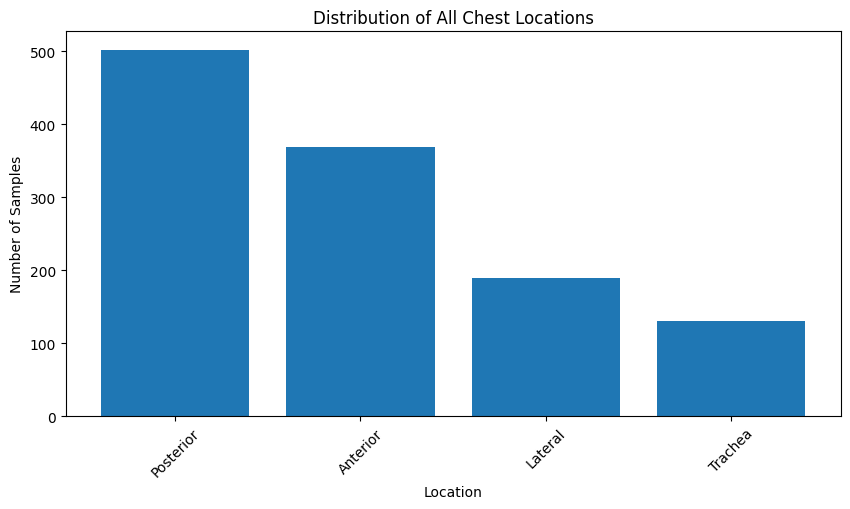

In [14]:
locations = [str(extract_location_metadata(f)) for f in audio_paths]
location_counts = Counter(locations)

# plot the distribution
plt.figure(figsize=(10,5))
plt.bar(location_counts.keys(), location_counts.values())
plt.xlabel('Location')
plt.ylabel('Number of Samples')
plt.title('Distribution of All Chest Locations')
plt.xticks(rotation=45)
plt.show()


We will not be using lateral, trachea, and unknown from our samples.

# PREPROCESSING

### Base and Augmented Model Splitting

In [15]:
# separate out the test set
train_val_paths, test_paths, y_train_val, y_test= train_test_split(
    audio_paths,labels, test_size=0.2, random_state=42, stratify=labels
)

# split the remaining paths into training and validation
train_paths, val_paths,y_train,y_val = train_test_split(
    train_val_paths, y_train_val,test_size=0.25, random_state=42, stratify=[labels[i] for i in range(len(train_val_paths))]
)

In [16]:
# set labels to variables
train_labels = to_categorical(y_train, num_classes=9)
val_labels = to_categorical(y_val, num_classes=9)
test_labels = to_categorical(y_test, num_classes=9)

### Base Model Features

In [17]:
base_features_train = extract_basic_model_features(train_paths)
base_features_val = extract_basic_model_features(val_paths)
base_features_test = extract_basic_model_features(test_paths)

In [18]:
print(base_features_train.shape) # 60%
print(base_features_val.shape) # 20%
print(base_features_test.shape) # 20%

(714, 193, 1)
(238, 193, 1)
(238, 193, 1)


### Data Augmented Model Features

In [19]:
# extract features from paths for augmentation
aug_features_train, aug_labels_train = extract_augmented_model_features(train_paths, y_train)

In [20]:
# Combine original and augmented features
aug_X_train = np.concatenate([base_features_train, aug_features_train], axis=0)
aug_y_train = np.concatenate([train_labels, to_categorical(aug_labels_train, num_classes=9)], axis=0)

# Keep validation and test sets as usual
aug_X_val = base_features_val
aug_y_val = val_labels

aug_X_test = base_features_test
aug_y_test = test_labels

In [21]:
print(aug_X_train.shape) 
print(aug_X_val.shape)
print(aug_X_test.shape)

(2856, 193, 1)
(238, 193, 1)
(238, 193, 1)


## Make CNN model bases

In [133]:
# Define model
# Source - Appendix 1
def create_cnn_model1(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )
    return model

In [134]:
# Define model; change = added dropout between conv layers and adjusted dropout values
def create_cnn_model2(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
        ]
    )
    return model

# Modeling

### Run Base Model

In [135]:
# model 1 + base training set
model_base_1 = create_cnn_model1(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history_base_1 = model_base_1.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - loss: 14.6721 - precision_20: 0.4525 - recall_20: 0.3546 - val_loss: 6.2337 - val_precision_20: 0.5485 - val_recall_20: 0.5462
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 4.7036 - precision_20: 0.4109 - recall_20: 0.3851 - val_loss: 3.4647 - val_precision_20: 0.6977 - val_recall_20: 0.5042
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 2.3788 - precision_20: 0.7460 - recall_20: 0.5285 - val_loss: 2.3361 - val_precision_20: 0.7500 - val_recall_20: 0.4916
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 1.6327 - precision_20: 0.7813 - recall_20: 0.4726 - val_loss: 1.4394 - val_precision_20: 0.8273 - val_recall_20: 0.3824
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 1.2571 - precision_20: 0.8809 - recall_20: 0.3888 - val_loss: 1.2023 - val_precision_20: 0.8364 - val_recall_20: 0.3866
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 1.0911 - precision_20: 0.8655 - recall_20: 0.4332 -

F1 Score: 79.13%
Precision: 86.47%
Recall: 75.21%
Loss: 0.5900


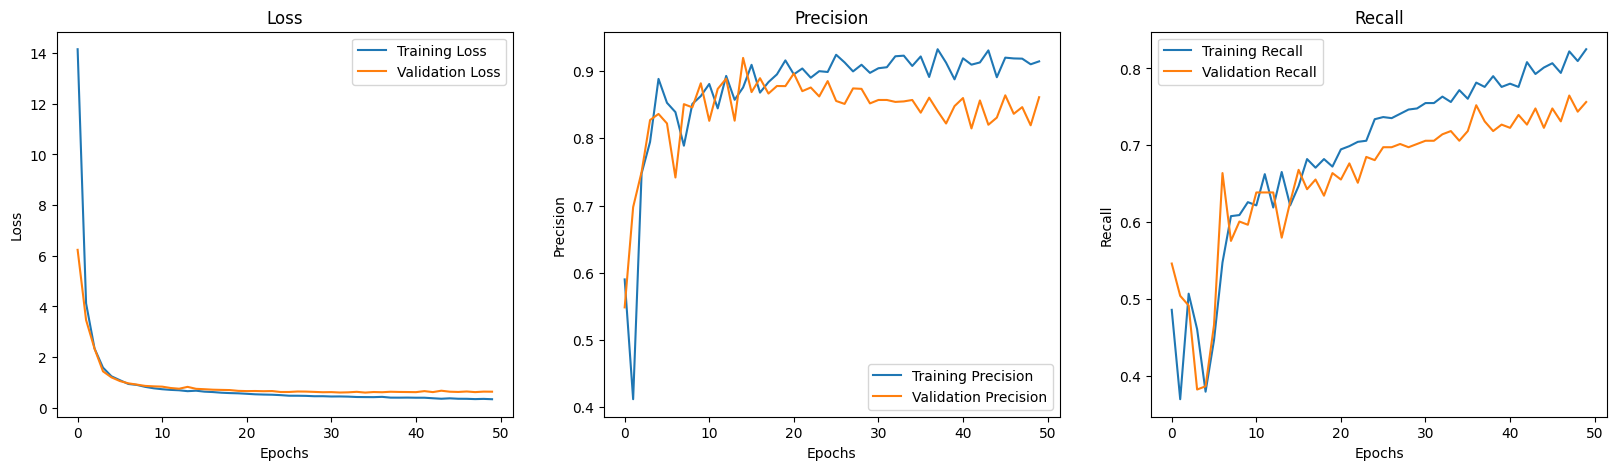

In [166]:
# plots for model 1 + base training set
# get predictions for F1 score calculation
y_pred = model_base_1.predict(base_features_test, batch_size=60, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels, axis=1)

# calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

score = model_base_1.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {f1:.2%}")
print(f"Precision: {score[1]:.2%}")
print(f"Recall: {score[2]:.2%}")
print("Loss: {:.4f}".format(score[0]))

plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.title('Loss')
plt.plot(history_base_1.history['loss'], label='Training Loss')
plt.plot(history_base_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision Score Plot
plt.subplot(1, 3, 2)
plt.title('Precision')
plt.plot(history_base_1.history['precision_20'], label='Training Precision')
plt.plot(history_base_1.history['val_precision_20'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 3, 3)
plt.title('Recall')
plt.plot(history_base_1.history['recall_20'], label='Training Recall')
plt.plot(history_base_1.history['val_recall_20'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Specificity per class:
Asthma: 0.91
BRON: 1.00
COPD: 0.88
Healthy: 0.95
Lung Fibrosis: 1.00
Plueral Effusion: 1.00
Pneumonia: 0.98
URTI: 1.00


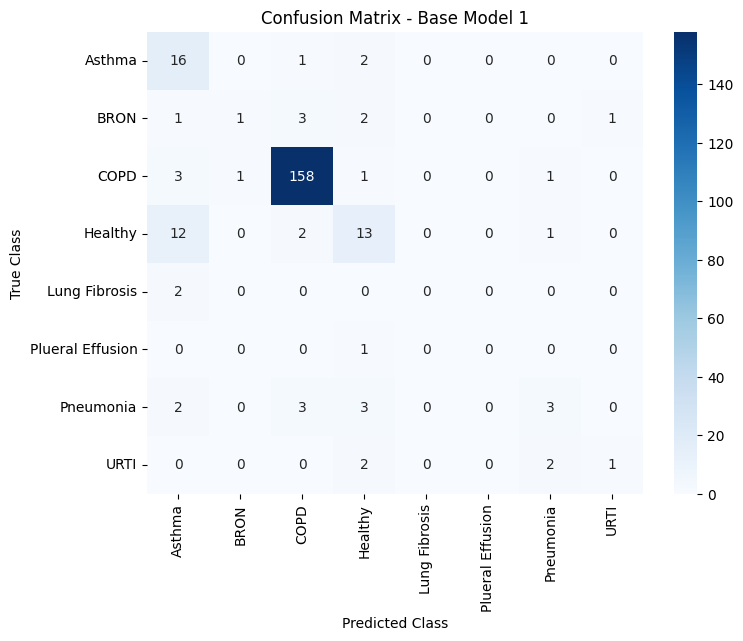

In [167]:
# Confusion matrix for model 1 + base training set
y_pred_probs1 = model_base_1.predict(base_features_test)
y_pred1 = np.argmax(y_pred_probs1, axis=1)

y_true1 = np.argmax(test_labels, axis=1)

cm1 = confusion_matrix(y_true1, y_pred1)

# Getting Specificity for each class
TP = np.diag(cm1)
FN = np.sum(cm1, axis=1) - TP
FP = np.sum(cm1, axis=0) - TP
TN = np.sum(cm1) - (TP + FP + FN)
specificity = TN / (TN + FP)
classes_in_test = np.unique(y_true1)

print("Specificity per class:")
for i, class_idx in enumerate(classes_in_test):
    print(f"{unique_labels[class_idx]}: {specificity[i]:.2f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
labels_for_heatmap = [unique_labels[i] for i in classes_in_test]
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=labels_for_heatmap, yticklabels=labels_for_heatmap)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - Base Model 1')
plt.show()

In [151]:
# model 2 + base training set
model_base_2 = create_cnn_model2(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history_base_2 = model_base_2.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - loss: 13.4794 - precision_21: 0.5105 - recall_21: 0.4059 - val_loss: 5.9188 - val_precision_21: 0.7113 - val_recall_21: 0.5798
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 3.6693 - precision_21: 0.7187 - recall_21: 0.5188 - val_loss: 2.4137 - val_precision_21: 0.1481 - val_recall_21: 0.0504
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 1.8234 - precision_21: 0.5711 - recall_21: 0.2051 - val_loss: 1.4923 - val_precision_21: 0.8119 - val_recall_21: 0.3445
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 1.3761 - precision_21: 0.8338 - recall_21: 0.3718 - val_loss: 1.4607 - val_precision_21: 0.8208 - val_recall_21: 0.3655
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 1.3304 - precision_21: 0.8320 - recall_21: 0.3964 - val_loss: 1.3304 - val_precision_21: 0.8165 - val_recall_21: 0.3739
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 1.1916 - precision_21: 0.8319 - recall_21: 0.4211 -

F1 Score: 76.58%
Precision: 92.00%
Recall: 67.65%
Loss: 0.5863


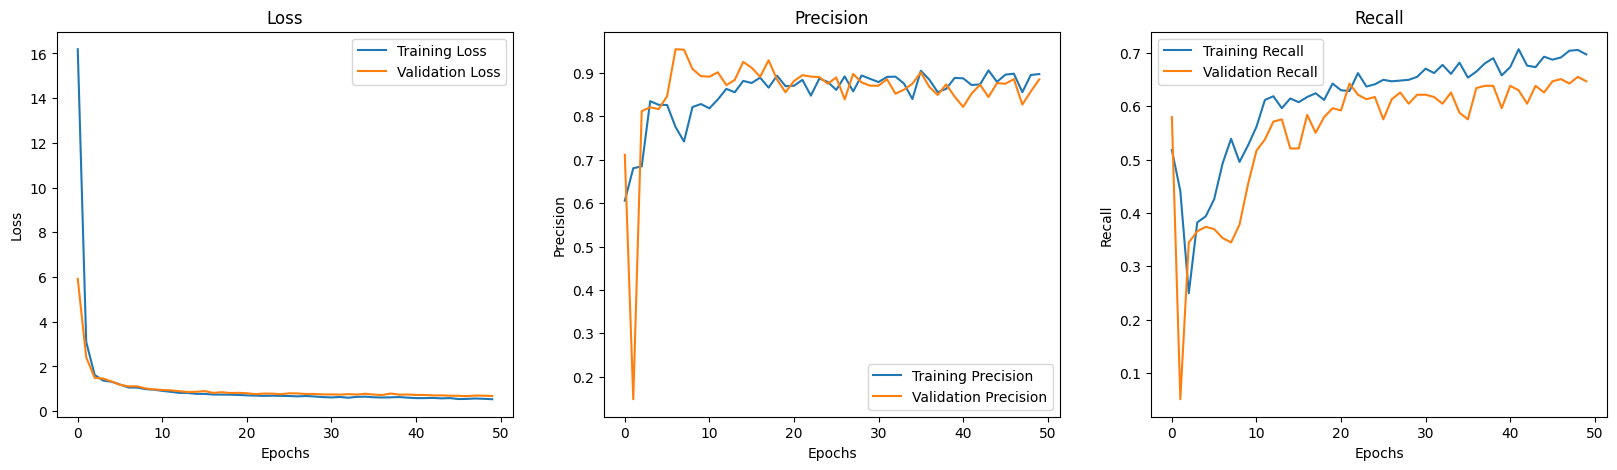

In [168]:
# plots for model 2 + base training set
# get predictions for F1 score calculation
y_pred = model_base_2.predict(base_features_test, batch_size=60, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels, axis=1)

# calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

score = model_base_2.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {f1:.2%}")
print(f"Precision: {score[1]:.2%}")
print(f"Recall: {score[2]:.2%}")
print("Loss: {:.4f}".format(score[0]))

plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.title('Loss')
plt.plot(history_base_2.history['loss'], label='Training Loss')
plt.plot(history_base_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision Score Plot
plt.subplot(1, 3, 2)
plt.title('Precision')
plt.plot(history_base_2.history['precision_21'], label='Training Precision')
plt.plot(history_base_2.history['val_precision_21'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 3, 3)
plt.title('Recall')
plt.plot(history_base_2.history['recall_21'], label='Training Recall')
plt.plot(history_base_2.history['val_recall_21'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Specificity per class:
Asthma: 0.95
BRON: 1.00
COPD: 0.77
Healthy: 0.91
Lung Fibrosis: 1.00
Plueral Effusion: 1.00
Pneumonia: 0.98
URTI: 1.00


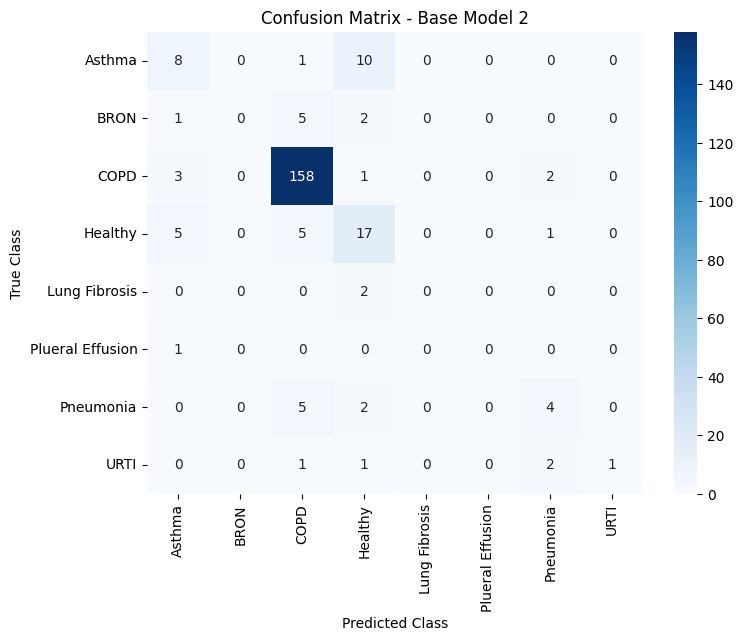

In [169]:
# Confusion matrix for model 2 + base training set
y_pred_probs2 = model_base_2.predict(base_features_test)
y_pred2 = np.argmax(y_pred_probs2, axis=1)

y_true2 = np.argmax(test_labels, axis=1)

cm2 = confusion_matrix(y_true2, y_pred2)
# Getting Specificity for each class
TP = np.diag(cm2)
FN = np.sum(cm2, axis=1) - TP
FP = np.sum(cm2, axis=0) - TP
TN = np.sum(cm2) - (TP + FP + FN)
specificity = TN / (TN + FP)

classes_in_test = np.unique(y_true2)
print("Specificity per class:")
for i, class_idx in enumerate(classes_in_test):
    print(f"{unique_labels[class_idx]}: {specificity[i]:.2f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
labels_for_heatmap = [unique_labels[i] for i in classes_in_test]
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=labels_for_heatmap, yticklabels=labels_for_heatmap)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - Base Model 2')
plt.show()

### EXPERIMENT 1: Audio Distortion

In [155]:
# model 1 + augmented training set
model_aug_1 = create_cnn_model1(input_shape=(aug_X_train.shape[1], aug_X_train.shape[2]), n_classes=9)
history_aug_1 = model_aug_1.fit(
    aug_X_train, 
    aug_y_train, 
    validation_data=(aug_X_val, aug_y_val), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - loss: 7.5170 - precision_22: 0.5099 - recall_22: 0.4278 - val_loss: 1.6156 - val_precision_22: 0.8378 - val_recall_22: 0.3908
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 1.2900 - precision_22: 0.8273 - recall_22: 0.4184 - val_loss: 0.9831 - val_precision_22: 0.8537 - val_recall_22: 0.5882
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 0.9045 - precision_22: 0.8407 - recall_22: 0.5700 - val_loss: 0.8512 - val_precision_22: 0.8757 - val_recall_22: 0.6218
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.7416 - precision_22: 0.8781 - recall_22: 0.6440 - val_loss: 0.7946 - val_precision_22: 0.8667 - val_recall_22: 0.6555
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.7054 - precision_22: 0.8724 - recall_22: 0.6473 - val_loss: 0.7248 - val_precision_22: 0.8556 - val_recall_22: 0.6471
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.6614 - precision_22: 0.8839 - recall_2

F1 Score: 75.93%
Precision: 83.02%
Recall: 73.95%
Loss: 0.7228


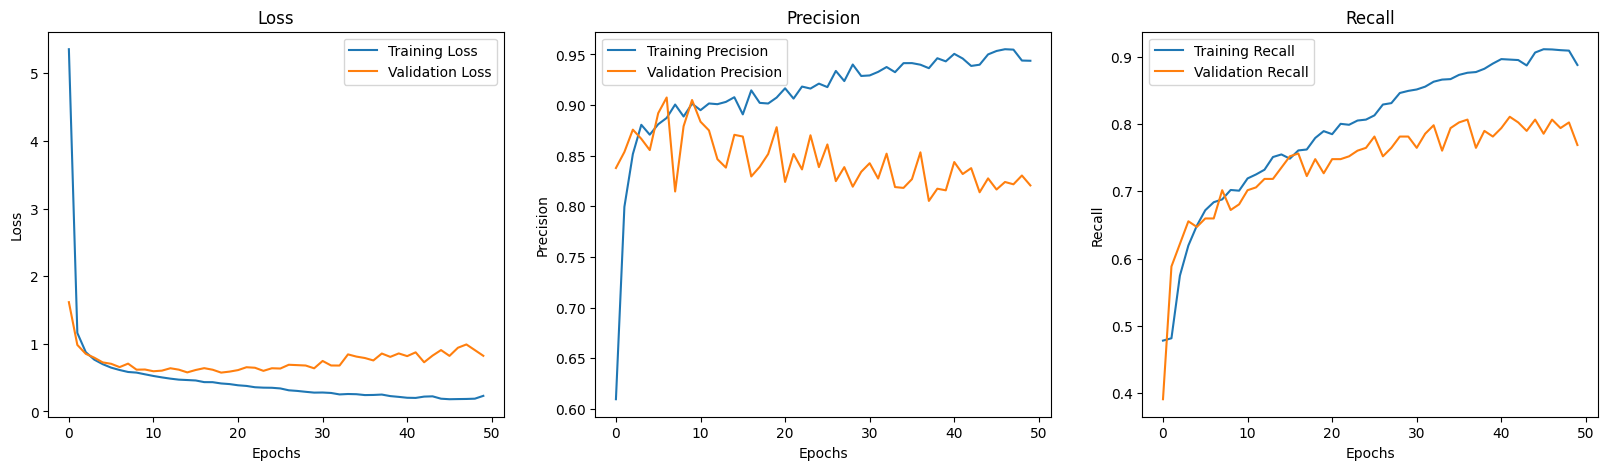

In [170]:
# plots for audio distortion model 1
# get predictions for F1 score calculation
y_pred = model_aug_1.predict(base_features_test, batch_size=60, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels, axis=1)

# calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

score = model_aug_1.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {f1:.2%}")
print(f"Precision: {score[1]:.2%}")
print(f"Recall: {score[2]:.2%}")
print("Loss: {:.4f}".format(score[0]))

plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.title('Loss')
plt.plot(history_aug_1.history['loss'], label='Training Loss')
plt.plot(history_aug_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision Score Plot
plt.subplot(1, 3, 2)
plt.title('Precision')
plt.plot(history_aug_1.history['precision_22'], label='Training Precision')
plt.plot(history_aug_1.history['val_precision_22'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 3, 3)
plt.title('Recall')
plt.plot(history_aug_1.history['recall_22'], label='Training Recall')
plt.plot(history_aug_1.history['val_recall_22'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Specificity per class:
Asthma: 0.94
BRON: 0.99
COPD: 0.74
Healthy: 0.95
Lung Fibrosis: 1.00
Plueral Effusion: 1.00
Pneumonia: 0.98
URTI: 0.99


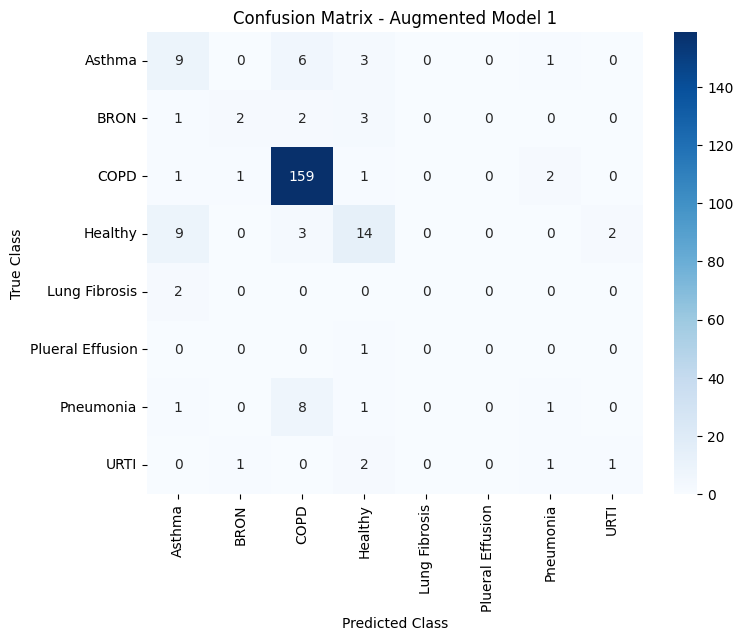

In [171]:
# Confusion matrix for model 1 + augmented training set
y_pred_probs_aug1 = model_aug_1.predict(base_features_test)
y_pred_aug1 = np.argmax(y_pred_probs_aug1, axis=1)

y_true_aug1 = np.argmax(test_labels, axis=1)

cm_aug1 = confusion_matrix(y_true_aug1, y_pred_aug1)

# Getting Specificity for each class
TP = np.diag(cm_aug1)
FN = np.sum(cm_aug1, axis=1) - TP
FP = np.sum(cm_aug1, axis=0) - TP
TN = np.sum(cm_aug1) - (TP + FP + FN)
specificity = TN / (TN + FP)

classes_in_test = np.unique(y_true_aug1)
print("Specificity per class:")
for i, class_idx in enumerate(classes_in_test):
    print(f"{unique_labels[class_idx]}: {specificity[i]:.2f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
labels_for_heatmap = [unique_labels[i] for i in classes_in_test]
sns.heatmap(cm_aug1, annot=True, fmt='d', cmap='Blues', xticklabels=labels_for_heatmap, yticklabels=labels_for_heatmap)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - Augmented Model 1')
plt.show()

In [157]:
# model 2 + augmented training set
model_aug_2 = create_cnn_model2(input_shape=(aug_X_train.shape[1], aug_X_train.shape[2]), n_classes=9)
history_aug_2 = model_aug_2.fit(
    aug_X_train, 
    aug_y_train, 
    validation_data=(aug_X_val, aug_y_val), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - loss: 8.3960 - precision_23: 0.4830 - recall_23: 0.4068 - val_loss: 1.6038 - val_precision_23: 0.8316 - val_recall_23: 0.3319
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 1.5000 - precision_23: 0.8514 - recall_23: 0.3121 - val_loss: 1.5214 - val_precision_23: 0.7043 - val_recall_23: 0.5504
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - loss: 1.1260 - precision_23: 0.7463 - recall_23: 0.5362 - val_loss: 0.9633 - val_precision_23: 0.7882 - val_recall_23: 0.6723
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - loss: 0.8885 - precision_23: 0.8235 - recall_23: 0.6056 - val_loss: 0.8228 - val_precision_23: 0.9020 - val_recall_23: 0.5798
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - loss: 0.8126 - precision_23: 0.8474 - recall_23: 0.6270 - val_loss: 0.7950 - val_precision_23: 0.8478 - val_recall_23: 0.6555
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.7818 - precision_23: 0.8300 - recall_2

F1 Score: 77.74%
Precision: 88.94%
Recall: 74.37%
Loss: 0.6406


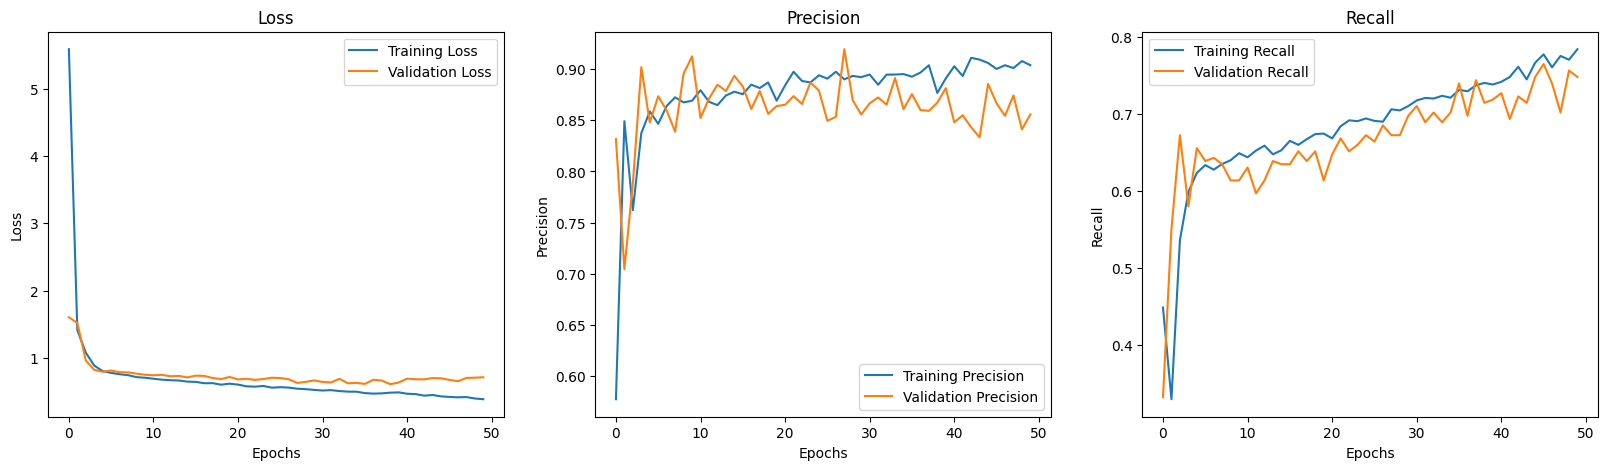

In [172]:
# plots for audio distortion model 2
# get predictions for F1 score calculation
y_pred = model_aug_2.predict(base_features_test, batch_size=60, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels, axis=1)

# calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

score = model_aug_2.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {f1:.2%}")
print(f"Precision: {score[1]:.2%}")
print(f"Recall: {score[2]:.2%}")
print("Loss: {:.4f}".format(score[0]))

plt.figure(figsize=(20, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.title('Loss')
plt.plot(history_aug_2.history['loss'], label='Training Loss')
plt.plot(history_aug_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision Score Plot
plt.subplot(1, 3, 2)
plt.title('Precision')
plt.plot(history_aug_2.history['precision_23'], label='Training Precision')
plt.plot(history_aug_2.history['val_precision_23'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 3, 3)
plt.title('Recall')
plt.plot(history_aug_2.history['recall_23'], label='Training Recall')
plt.plot(history_aug_2.history['val_recall_23'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Specificity per class:
Asthma: 0.97
BRON: 1.00
COPD: 0.89
Healthy: 0.89
Lung Fibrosis: 0.99
Plueral Effusion: 0.99
Pneumonia: 1.00
URTI: 0.98


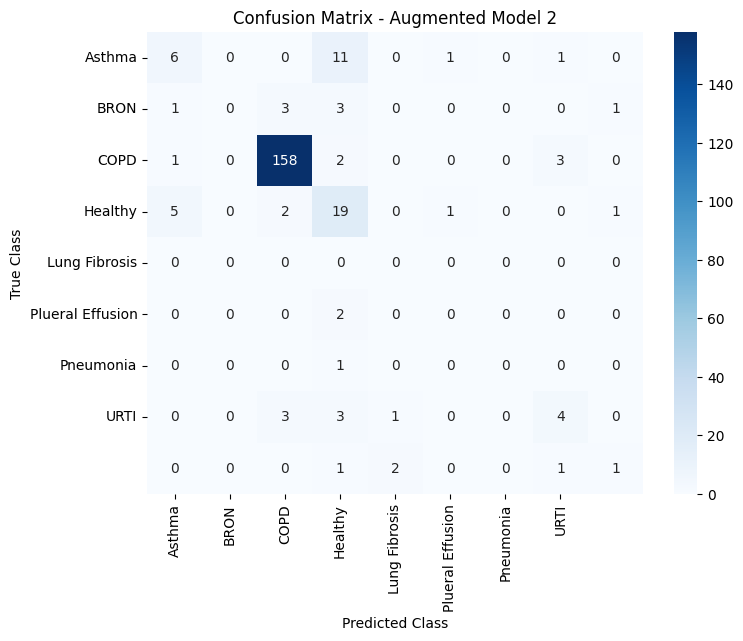

In [173]:
# Confusion matrix for model 2 + augmented training set
y_pred_probs_aug2 = model_aug_2.predict(base_features_test)
y_pred_aug2 = np.argmax(y_pred_probs_aug2, axis=1)

y_true_aug2 = np.argmax(test_labels, axis=1)

cm_aug2 = confusion_matrix(y_true_aug2, y_pred_aug2)

# Getting Specificity for each class
TP = np.diag(cm_aug2)
FN = np.sum(cm_aug2, axis=1) - TP
FP = np.sum(cm_aug2, axis=0) - TP
TN = np.sum(cm_aug2) - (TP + FP + FN)
specificity = TN / (TN + FP)

classes_in_test = np.unique(y_true_aug2)
print("Specificity per class:")
for i, class_idx in enumerate(classes_in_test):
    print(f"{unique_labels[class_idx]}: {specificity[i]:.2f}")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
labels_for_heatmap = [unique_labels[i] for i in classes_in_test]
sns.heatmap(cm_aug2, annot=True, fmt='d', cmap='Blues', xticklabels=labels_for_heatmap, yticklabels=labels_for_heatmap)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - Augmented Model 2')
plt.show()

### EXPERIMENT 2: Training of specific locations

Training on Anterior
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 2.6195 - precision_27: 0.6525 - recall_27: 0.3105 - val_loss: 11.0734 - val_precision_27: 0.7297 - val_recall_27: 0.7297
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 8.6388 - precision_27: 0.7309 - recall_27: 0.7287 - val_loss: 2.7411 - val_precision_27: 0.6613 - val_recall_27: 0.5541
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 2.3265 - precision_27: 0.6764 - recall_27: 0.5443 - val_loss: 2.1719 - val_precision_27: 0.7447 - val_recall_27: 0.4730
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.7444 - precision_27: 0.7482 - recall_27: 0.4811 - val_loss: 2.6370 - val_precision_27: 0.7647 - val_recall_27: 0.5270
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.9347 - precision_27: 0.7908 - recall_27: 0.6009 - val_loss: 2.5565 - val_precision_27: 0.7647 - val_recall_27: 0.5270
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.7806 - precision_27: 0.8001 - rec

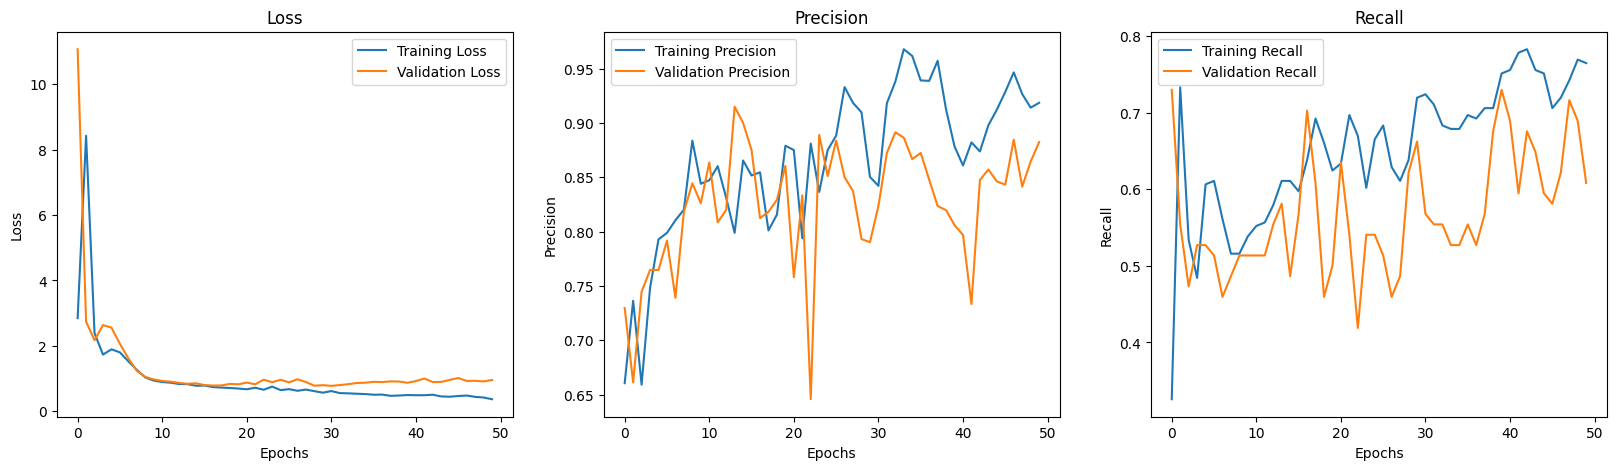


Specificity per class for Anterior:
Asthma: 0.99
BRON: 1.00
COPD: 0.85
Healthy: 0.88
Pneumonia: 0.93
URTI: 0.99


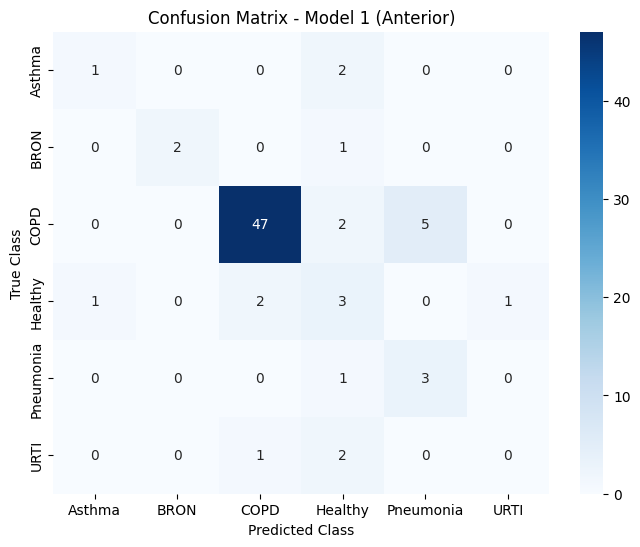

Training on Posterior
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 362ms/step - loss: 11.3394 - precision_28: 0.2292 - recall_28: 0.1222 - val_loss: 17.8248 - val_precision_28: 0.5446 - val_recall_28: 0.5446
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 14.9181 - precision_28: 0.5470 - recall_28: 0.5300 - val_loss: 3.5503 - val_precision_28: 0.4362 - val_recall_28: 0.4059
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 4.1122 - precision_28: 0.4303 - recall_28: 0.3983 - val_loss: 3.0134 - val_precision_28: 0.2396 - val_recall_28: 0.2277
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.6505 - precision_28: 0.3620 - recall_28: 0.3344 - val_loss: 2.4308 - val_precision_28: 0.6275 - val_recall_28: 0.3168
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 2.1901 - precision_28: 0.6740 - recall_28: 0.4111 - val_loss: 2.2980 - val_precision_28: 0.6226 - val_recall_28: 0.3267
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 2.1251 - precision_28: 0.65

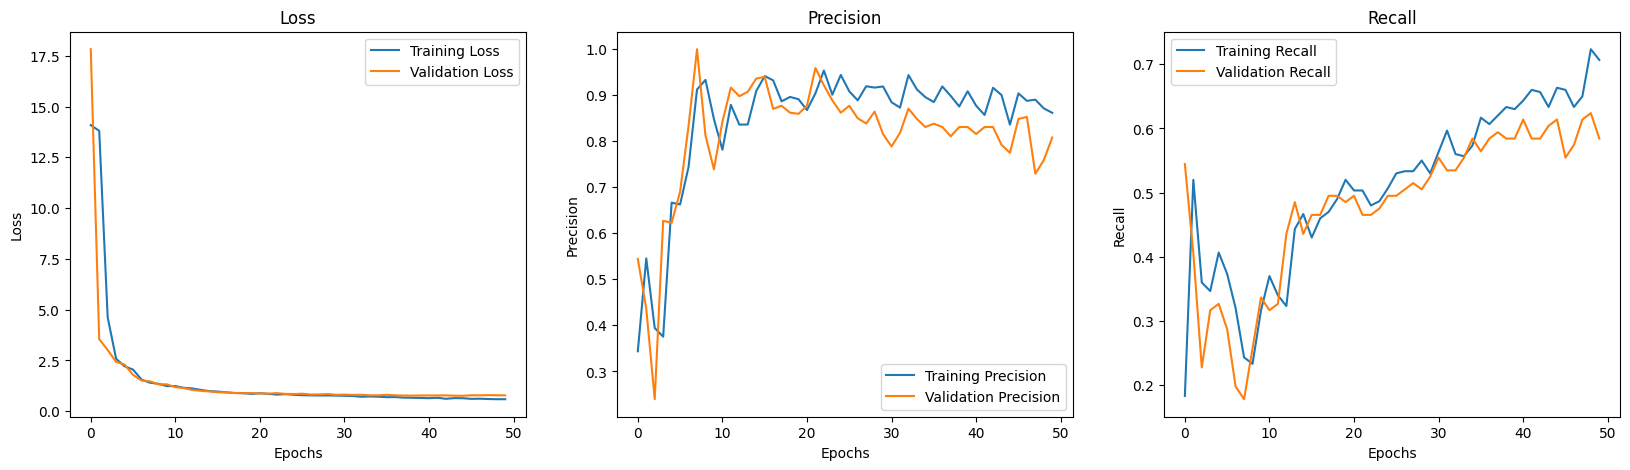


Specificity per class for Posterior:
Asthma: 0.90
BRON: 1.00
COPD: 0.78
Healthy: 0.86
Lung Fibrosis: 1.00
Plueral Effusion: 1.00
Pneumonia: 0.98
URTI: 1.00


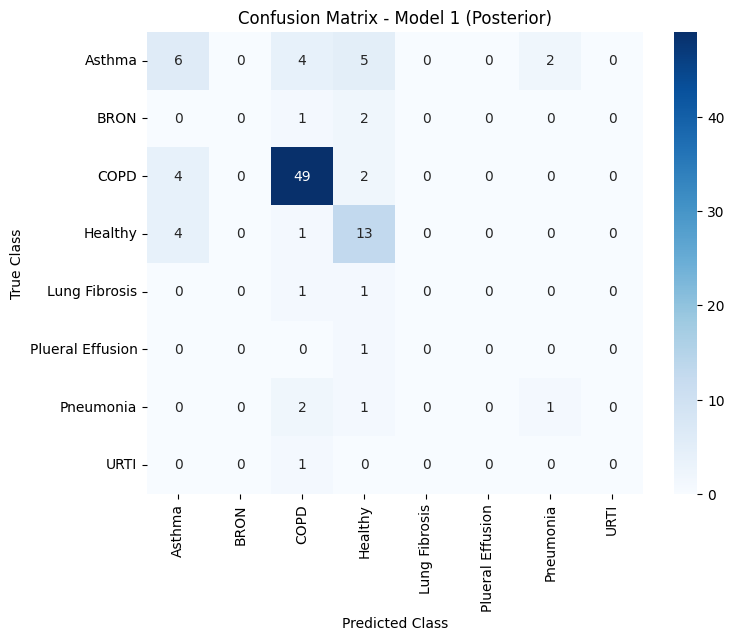

In [164]:
locations = ['Anterior','Posterior']

results_locations_1 = {}
history_location_1_dict = {}
confusion_matrices = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model_location_1 = create_cnn_model1(input_shape=(location_features_train.shape[1], location_features_train.shape[2]), n_classes=9)
    history_location_1 = model_location_1.fit(
        location_features_train, 
        y_train, 
        validation_data=(location_features_val, y_val), 
        epochs=50, 
        batch_size=200
    )
    history_location_1_dict[loc] = history_location_1.history

    score = model_location_1.evaluate(location_features_test, y_test, verbose=0)
    results_locations_1[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2]
    }
    y_pred_loc1 = np.argmax(model_location_1.predict(location_features_test), axis=1)
    y_true_loc1 = np.argmax(y_test, axis=1)
    # get predictions for F1 score calculation

    # calculate F1 score
    f1 = f1_score(y_true_loc1, y_pred_loc1, average='weighted')
    
    print(f"F1 Score: {f1:.2%}")
    print(f"Precision: {results_locations_1[loc]['precision']:.2%}")
    print(f"Recall: {results_locations_1[loc]['recall']:.2%}")
    print("Loss: {:.4f}".format(results_locations_1[loc]['loss']))
    
    # finds the correct metric names
    precision_key = [k for k in history_location_1_dict[loc].keys() if 'precision' in k and not k.startswith('val_')][0]
    val_precision_key = [k for k in history_location_1_dict[loc].keys() if 'val_precision' in k][0]
    recall_key = [k for k in history_location_1_dict[loc].keys() if 'recall' in k and not k.startswith('val_')][0]
    val_recall_key = [k for k in history_location_1_dict[loc].keys() if 'val_recall' in k][0]

    plt.figure(figsize=(20, 5))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.title('Loss')
    plt.plot(history_location_1_dict[loc]['loss'], label='Training Loss')
    plt.plot(history_location_1_dict[loc]['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Precision Score Plot
    plt.subplot(1, 3, 2)
    plt.title('Precision')
    plt.plot(history_location_1_dict[loc][precision_key], label='Training Precision')
    plt.plot(history_location_1_dict[loc][val_precision_key], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall Score Plot
    plt.subplot(1, 3, 3)
    plt.title('Recall')
    plt.plot(history_location_1_dict[loc][recall_key], label='Training Recall')
    plt.plot(history_location_1_dict[loc][val_recall_key], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.show()

    cm_loc1 = confusion_matrix(y_true_loc1, y_pred_loc1)
    confusion_matrices[loc] = cm_loc1

    # Specificity per class
    TP = np.diag(cm_loc1)
    FN = np.sum(cm_loc1, axis=1) - TP
    FP = np.sum(cm_loc1, axis=0) - TP
    TN = np.sum(cm_loc1) - (TP + FP + FN)
    specificity = TN / (TN + FP)

    classes_in_test = np.unique(y_true_loc1)
    print(f"\nSpecificity per class for {loc}:")
    for i, class_idx in enumerate(classes_in_test):
        print(f"{unique_labels[class_idx]}: {specificity[i]:.2f}")

    # Confusion matrix plot
    plt.figure(figsize=(8, 6))
    labels_for_heatmap = [unique_labels[i] for i in classes_in_test]
    sns.heatmap(cm_loc1, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_for_heatmap,
                yticklabels=labels_for_heatmap)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Confusion Matrix - Model 1 ({loc})')
    plt.show()

Training on Anterior
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - loss: 8.7024 - precision_31: 0.1471 - recall_31: 0.0780 - val_loss: 20.9875 - val_precision_31: 0.7297 - val_recall_31: 0.7297
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 18.0553 - precision_31: 0.7384 - recall_31: 0.7384 - val_loss: 9.9542 - val_precision_31: 0.6081 - val_recall_31: 0.6081
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 7.8926 - precision_31: 0.7089 - recall_31: 0.7089 - val_loss: 3.8083 - val_precision_31: 0.5694 - val_recall_31: 0.5541
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 3.1958 - precision_31: 0.6146 - recall_31: 0.6062 - val_loss: 1.9579 - val_precision_31: 0.4510 - val_recall_31: 0.3108
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 1.8188 - precision_31: 0.5583 - recall_31: 0.4236 - val_loss: 1.3607 - val_precision_31: 1.0000 - val_recall_31: 0.3243
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.3084 - precision_31: 0.8953 - 

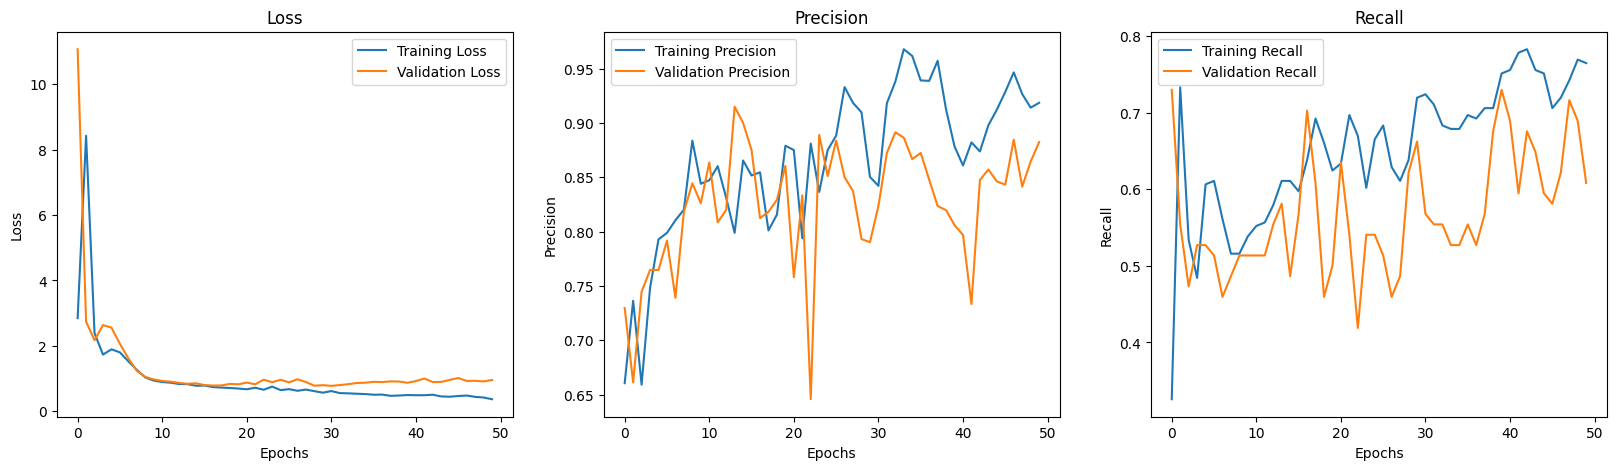


Specificity per class for Anterior:
Asthma: 0.96
BRON: 1.00
COPD: 0.75
Healthy: 0.97
Pneumonia: 0.93
URTI: 0.89


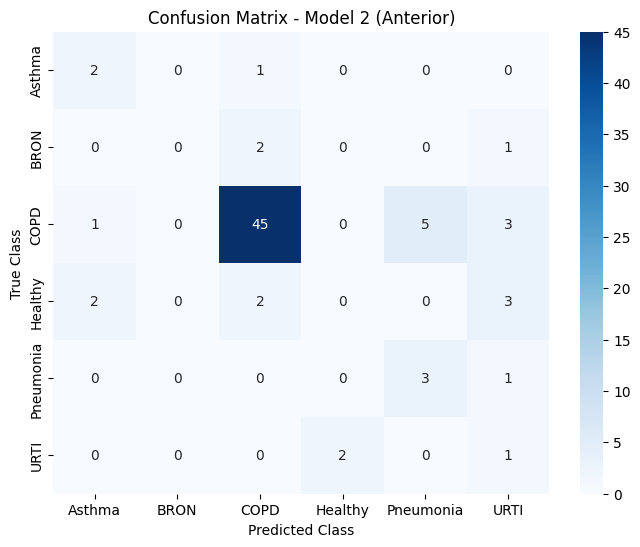

Training on Posterior
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - loss: 16.2623 - precision_32: 0.2013 - recall_32: 0.1350 - val_loss: 10.3377 - val_precision_32: 0.5446 - val_recall_32: 0.5446
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 14.0668 - precision_32: 0.3893 - recall_32: 0.3878 - val_loss: 4.1422 - val_precision_32: 0.5294 - val_recall_32: 0.4455
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 4.5954 - precision_32: 0.5308 - recall_32: 0.5028 - val_loss: 3.8603 - val_precision_32: 0.4536 - val_recall_32: 0.4356
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 4.3614 - precision_32: 0.4812 - recall_32: 0.4772 - val_loss: 2.8944 - val_precision_32: 0.5000 - val_recall_32: 0.4059
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 3.0354 - precision_32: 0.5136 - recall_32: 0.4556 - val_loss: 2.1833 - val_precision_32: 0.6667 - val_recall_32: 0.2772
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 2.1591 - precision_32: 0.65

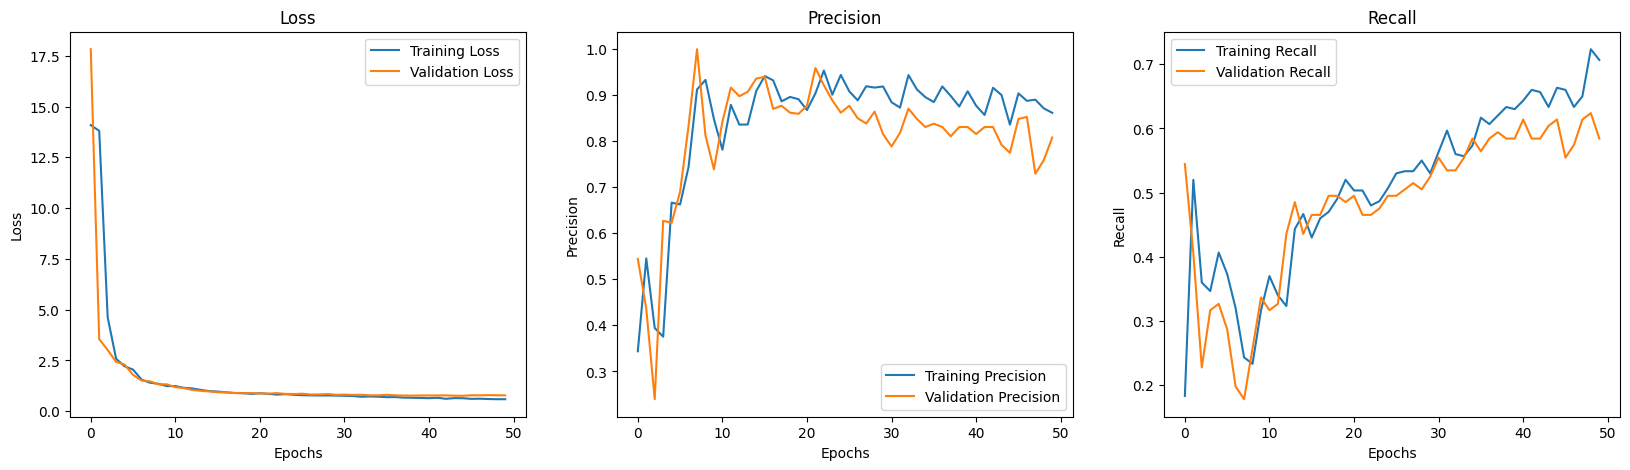


Specificity per class for Posterior:
Asthma: 0.95
BRON: 1.00
COPD: 0.89
Healthy: 0.76
Lung Fibrosis: 1.00
Plueral Effusion: 1.00
Pneumonia: 1.00
URTI: 1.00


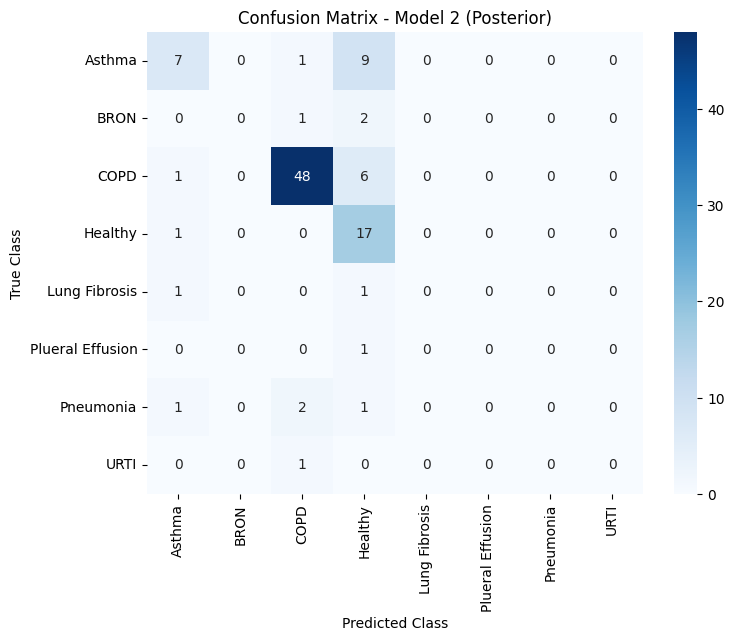

In [174]:
results_locations_2 = {}
history_location_2_dict = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model_location_2 = create_cnn_model2(input_shape=(location_features_train.shape[1], location_features_train.shape[2]), n_classes=9)
    history_location_2 = model_location_2.fit(
        location_features_train, 
        y_train, 
        validation_data=(location_features_val, y_val), 
        epochs=50, 
        batch_size=200
    )
    history_location_2_dict[loc] = history_location_2.history

    score = model_location_2.evaluate(location_features_test, y_test, verbose=0)
    results_locations_2[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2]
    }
    y_pred_loc1 = np.argmax(model_location_2.predict(location_features_test), axis=1)
    y_true_loc1 = np.argmax(y_test, axis=1)
    # get predictions for F1 score calculation

    # calculate F1 score
    f1 = f1_score(y_true_loc1, y_pred_loc1, average='weighted')
    
    print(f"F1 Score: {f1:.2%}")
    print(f"Precision: {results_locations_1[loc]['precision']:.2%}")
    print(f"Recall: {results_locations_1[loc]['recall']:.2%}")
    print("Loss: {:.4f}".format(results_locations_1[loc]['loss']))
    
    # finds the correct metric names
    precision_key = [k for k in history_location_1_dict[loc].keys() if 'precision' in k and not k.startswith('val_')][0]
    val_precision_key = [k for k in history_location_1_dict[loc].keys() if 'val_precision' in k][0]
    recall_key = [k for k in history_location_1_dict[loc].keys() if 'recall' in k and not k.startswith('val_')][0]
    val_recall_key = [k for k in history_location_1_dict[loc].keys() if 'val_recall' in k][0]

    plt.figure(figsize=(20, 5))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.title('Loss')
    plt.plot(history_location_1_dict[loc]['loss'], label='Training Loss')
    plt.plot(history_location_1_dict[loc]['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Precision Score Plot
    plt.subplot(1, 3, 2)
    plt.title('Precision')
    plt.plot(history_location_1_dict[loc][precision_key], label='Training Precision')
    plt.plot(history_location_1_dict[loc][val_precision_key], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall Score Plot
    plt.subplot(1, 3, 3)
    plt.title('Recall')
    plt.plot(history_location_1_dict[loc][recall_key], label='Training Recall')
    plt.plot(history_location_1_dict[loc][val_recall_key], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.show()

    cm_loc1 = confusion_matrix(y_true_loc1, y_pred_loc1)
    confusion_matrices[loc] = cm_loc1

    # Specificity per class
    TP = np.diag(cm_loc1)
    FN = np.sum(cm_loc1, axis=1) - TP
    FP = np.sum(cm_loc1, axis=0) - TP
    TN = np.sum(cm_loc1) - (TP + FP + FN)
    specificity = TN / (TN + FP)

    classes_in_test = np.unique(y_true_loc1)
    print(f"\nSpecificity per class for {loc}:")
    for i, class_idx in enumerate(classes_in_test):
        print(f"{unique_labels[class_idx]}: {specificity[i]:.2f}")

    # Confusion matrix plot
    plt.figure(figsize=(8, 6))
    labels_for_heatmap = [unique_labels[i] for i in classes_in_test]
    sns.heatmap(cm_loc1, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_for_heatmap,
                yticklabels=labels_for_heatmap)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Confusion Matrix - Model 2 ({loc})')
    plt.show()

# Appendix

1. We based our intial architecture for our CNN and CNN plots (like loss) off of this code: https://www.kaggle.com/code/markdenton/cnn-disease-classification-linked-features-95


2. Used ChatGPT free version to help format the input array for our CNN models:
    `padded = padded[..., np.newaxis]`